<font size=8> --Patch Attack Tensorflow-- </font>

<font size=6> Packages and Libraries </font>

In [1]:
# Install requirements
! pip install keras
! pip install tensorflow-addons
! pip install --upgrade tf_slim
! pip install git+https://github.com/nottombrown/imagenet_stubs --upgrade

  Cloning https://github.com/nottombrown/imagenet_stubs to c:\users\gdkpy\appdata\local\temp\pip-req-build-lvoywn0n
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs 'C:\Users\gdkpy\AppData\Local\Temp\pip-req-build-lvoywn0n'
La syntaxe de la commande n’est pas correcte.
'wget' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [80]:
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf

import math
from matplotlib import pylab as P
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict

import os
import os.path as osp
import numpy as np
import pickle
import PIL.Image
import scipy
import time
import glob
import random

import keras
from keras import applications
from keras import backend as K
from keras.preprocessing import image
import numpy as np

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name, name_to_label

<font size=6> Initialization </font>

In [81]:
TARGET_LABEL = name_to_label('toaster') 
PATCH_SHAPE = (299, 299, 3)
BATCH_SIZE = 16

# Ensemble of models
NAME_TO_MODEL = {
    'xception': applications.xception.Xception,
    'vgg16': applications.vgg16.VGG16,
    'vgg19': applications.vgg19.VGG19,
    'resnet50': applications.ResNet50,
    'inceptionv3': applications.inception_v3.InceptionV3,
}

MODEL_NAMES = ['resnet50', 'xception', 'inceptionv3', 'vgg16', 'vgg19']

# Data augmentation
SCALE_MIN = 0.3
SCALE_MAX = 1.5
ROTATE_MAX = np.pi/8     # 22.5 degrees 
MAX_ROTATION = 22.5

# Local data dir to write files to
DATA_DIR = 'D:/Sorbonne/m2s1/Machine_Learning_Avance/projet/adversarial_patch'  

<font size=6> Load image </font>

In [ ]:
def _convert(im):
    return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
    plt.axis('off')
    plt.imshow(_convert(im), interpolation="nearest")
    plt.show()

def load_image(image_path):
    im = PIL.Image.open(image_path)
    im = im.resize((299, 299), PIL.Image.ANTIALIAS)
    if image_path.endswith('.png'):
        ch = 4
    else:
        ch = 3
    im = np.array(im.getdata()).reshape(im.size[0], im.size[1], ch)[:,:,:3]
    return im / 127.5 - 1

#Image loader to load ImageNet images.
class StubImageLoader():

    def __init__(self):
        self.images = []
        self.toaster_image = None
   
        for image_path in imagenet_stubs.get_image_paths():
            im = load_image(image_path)

        if image_path.endswith('toaster.jpg'):
            self.toaster_image = im
        else:
            self.images.append(im)

    def get_images(self):
        return random.sample(self.images, BATCH_SIZE)

image_loader = StubImageLoader()

for example_image in image_loader.get_images()[:2]:
    print("Example true image:")
    show(example_image)

<font size=6> Patch transformations </font>

Test image with random transform: 1
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


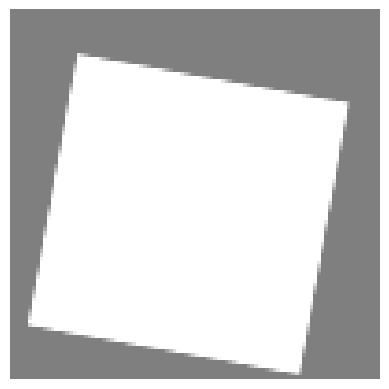

Test image with random transform: 2


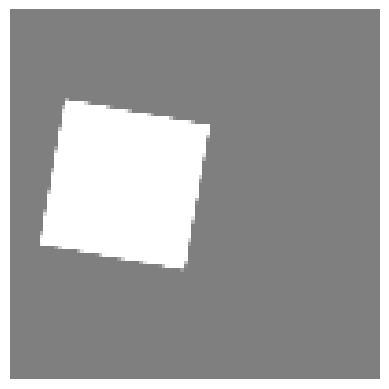

In [5]:
import tensorflow.compat.v1 as tf
import tensorflow_addons as tfa
tf.compat.v1.disable_eager_execution()

def _transform_vector(width, x_shift, y_shift, im_scale, rot_in_degrees):

    rot = float(rot_in_degrees) / 90. * (math.pi/2)

    rot_matrix = np.array(
      [[math.cos(-rot), -math.sin(-rot)],
      [math.sin(-rot), math.cos(-rot)]]
    )
  
    inv_scale = 1. / im_scale 
    xform_matrix = rot_matrix * inv_scale
    a0, a1 = xform_matrix[0]
    b0, b1 = xform_matrix[1]
  
    x_origin = float(width) / 2
    y_origin = float(width) / 2
  
    x_origin_shifted, y_origin_shifted = np.matmul(
      xform_matrix,
      np.array([x_origin, y_origin]),
    )

    x_origin_delta = x_origin - x_origin_shifted
    y_origin_delta = y_origin - y_origin_shifted

    a2 = x_origin_delta - (x_shift/(2*im_scale))
    b2 = y_origin_delta - (y_shift/(2*im_scale))

    return np.array([a0, a1, a2, b0, b1, b2, 0, 0]).astype(np.float32)

def test_random_transform(min_scale=0.5, max_scale=1.0,  max_rotation=22.5):
    img_shape = [100,100,3]
    img = np.ones(img_shape)
  
    sess = tf.Session()
    image_in = tf.placeholder(dtype=tf.float32, shape=img_shape)
    width = img_shape[0]
  
    def _random_transformation():
        im_scale = np.random.uniform(low=min_scale, high=1.0)
    
        padding_after_scaling = (1-im_scale) * width
        x_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
        y_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
    
    
        rot = np.random.uniform(-max_rotation, max_rotation)
    
        return _transform_vector(width, 
                                     x_shift=x_delta,
                                     y_shift=y_delta,
                                     im_scale=im_scale, 
                                     rot_in_degrees=rot)

    random_xform_vector = tf.py_func(_random_transformation, [], tf.float32)
    random_xform_vector.set_shape([8])

    output = tfa.image.transform(image_in, random_xform_vector , "BILINEAR")
  
    xformed_img = sess.run(output, feed_dict={
      image_in: img
    })
  
    show(xformed_img)

for i in range(2):
    print("Test image with random transform: %s" % (i+1))
    test_random_transform(min_scale=0.25, max_scale=2.0, max_rotation=22.5)

<font size=6> Class definition </font>

In [67]:
def get_peace_mask(shape):
    path = osp.join(DATA_DIR, "peace_sign.png")
    pic = PIL.Image.open(path)
    pic = pic.resize(shape[:2], PIL.Image.ANTIALIAS)
    if path.endswith('.png'):
        ch = 4
    else:
        ch = 3
    pic = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], ch)
    pic = pic / 127.5 - 1
    pic = pic[:,:,3]

    peace_mask = (pic + 1.0) / 2
    peace_mask = np.expand_dims(peace_mask, 2)
    peace_mask = np.broadcast_to(peace_mask, shape)
    return peace_mask

def get_tie_dye(shape):
    path = osp.join(DATA_DIR, "tie_dye.png")
    pic = PIL.Image.open(path)
    pic = pic.resize(shape[:2], PIL.Image.ANTIALIAS)
    if path.endswith('.png'):
        ch = 4
    else:
        ch = 3
    pic = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], ch)
    pic = pic / 127.5 - 1
    pic = pic[:,:,3]

    tie_dye = (pic + 1.0) / 2
    tie_dye = np.expand_dims(tie_dye, 2)
    tie_dye = np.broadcast_to(tie_dye, shape)
    return tie_dye


def _circle_mask(shape, sharpness = 40):
    assert shape[0] == shape[1], "circle_mask received a bad shape: " + shape

    diameter = shape[0]  
    x = np.linspace(-1, 1, diameter)
    y = np.linspace(-1, 1, diameter)
    xx, yy = np.meshgrid(x, y, sparse=True)
    z = (xx**2 + yy**2) ** sharpness

    mask = 1 - np.clip(z, -1, 1)
    mask = np.expand_dims(mask, axis=2)
    mask = np.broadcast_to(mask, shape).astype(np.float32)
    return mask

def _gen_target_ys():
    label = TARGET_LABEL
    y_one_hot = np.zeros(1000)
    y_one_hot[label] = 1.0
    y_one_hot = np.tile(y_one_hot, (BATCH_SIZE, 1))
    return y_one_hot

TARGET_ONEHOT = _gen_target_ys()
      
"la class pour la manipulation de l'entrainement sur un seul classifier"
class ModelContainer():
  
    def __init__(self, model_name, verbose=True, peace_mask=None, peace_mask_overlay=0.0, tie_dye=None):
    # peace_mask: None, "forward"           tie_dye : None, "forward"
        self.model_name = model_name
        self.graph = tf.Graph()
        self.sess = tf.Session(graph=self.graph)
        self.peace_mask = peace_mask
        self.tie_dye = tie_dye
        self.patch_shape = PATCH_SHAPE
        self._peace_mask_overlay = peace_mask_overlay
        self.load_model(verbose=verbose)

    
    def patch(self, new_patch=None):
    # Return itself if it set a new patch, or the current patch.
        if new_patch is None:
            return self._run(self._clipped_patch)
      
        self._run(self._assign_patch, {self._patch_placeholder: new_patch})
        return self
  
    def reset_patch(self):
    # Reset the adversarial patch to zeros.
        self.patch(np.zeros(self.patch_shape))
    
    def train_step(self, images=None, target_ys=None, learning_rate=5.0, scale=(0.1, 1.0), dropout=None, patch_disguise=None, disguise_alpha=None):
        
        if images is None:
            images = image_loader.get_images()
        if target_ys is None:
            target_ys = TARGET_ONEHOT
    
        feed_dict =  {self._image_input: images, 
                        self._target_ys: target_ys,
                        self._learning_rate: learning_rate}
    
        if patch_disguise is not None:
            if disguise_alpha is None:
                raise ValueError("You need disguise_alpha")
            feed_dict[self.patch_disguise] = patch_disguise
            feed_dict[self.disguise_alpha] = disguise_alpha
    

        loss, _ = self._run([self._loss, self._train_op], feed_dict, scale=scale, dropout=dropout) 
        return loss
  
    def inference_batch(self, images=None, target_ys=None, scale=None):

        if images is None:
            images = image_loader.get_images()
        if target_ys is None:
            target_ys = TARGET_ONEHOT
      
        feed_dict = {self._image_input: images, self._target_ys: target_ys}

        loss_per_example, ps, ims = self._run([self._loss_per_example, self._probabilities, self._patched_input],
                            feed_dict, scale=scale)
        return loss_per_example, ps, ims
  
    def load_model(self, verbose=True):
   
        model = NAME_TO_MODEL[self.model_name]
        if self.model_name in ['xception', 'inceptionv3', 'mobilenet']:
            keras_mode = False
        else:
            keras_mode = True
        patch = None

        self._make_model_and_ops(model, keras_mode, patch, verbose)
            
    def _run(self, target, feed_dict=None, scale=None, dropout=None):
        
        K.set_session(self.sess)
        if feed_dict is None:
            feed_dict = {}
        feed_dict[self.learning_phase] = False
    
        if scale is not None:
            if isinstance(scale, (tuple, list)):
                scale_min, scale_max = scale
            else:
                scale_min, scale_max = (scale, scale)
            feed_dict[self.scale_min] = scale_min
            feed_dict[self.scale_max] = scale_max
         
        if dropout is not None:
            feed_dict[self.dropout] = dropout
        return self.sess.run(target, feed_dict=feed_dict)
  
  
    def _make_model_and_ops(self, M, keras_mode, patch_val, verbose):
        
        start = time.time()
        K.set_session(self.sess)
        with self.sess.graph.as_default():
            self.learning_phase = K.learning_phase()

            image_shape = (299, 299, 3)
            self._image_input = keras.layers.Input(shape=image_shape)
      
            self.scale_min = tf.placeholder_with_default(SCALE_MIN, [])
            self.scale_max = tf.placeholder_with_default(SCALE_MAX, [])
            self._scales = tf.random_uniform([BATCH_SIZE], minval=self.scale_min, maxval=self.scale_max)

            image_input = self._image_input
            self.patch_disguise = tf.placeholder_with_default(tf.zeros(self.patch_shape), shape=self.patch_shape)
            self.disguise_alpha = tf.placeholder_with_default(0.0, [])
            patch = tf.get_variable("patch", self.patch_shape, dtype=tf.float32, initializer=tf.zeros_initializer)
            self._patch_placeholder = tf.placeholder(dtype=tf.float32, shape=self.patch_shape)
            self._assign_patch = tf.assign(patch, self._patch_placeholder)

            modified_patch = patch

            def clip_to_valid_image(x):    
                return tf.clip_by_value(x, clip_value_min=-1.,clip_value_max=1.)

            if self.peace_mask == 'forward':
                mask = get_peace_mask(self.patch_shape)
                modified_patch = patch - np.ones(self.patch_shape) * mask*255 + mask * self._peace_mask_overlay # black peace sign
                # modified_patch = patch + np.ones(self.patch_shape) * mask* self._peace_mask_overlay           # white peace sign

            if self.tie_dye == 'forward':
                mask = get_tie_dye(self.patch_shape)
                modified_patch = patch + np.ones(self.patch_shape) * mask* 0.9         # tie dye
        
            self._clipped_patch = clip_to_valid_image(modified_patch)     
            if keras_mode:
                image_input = tf.image.resize_images(image_input, (224, 224))
                image_shape = (224, 224, 3)
                modified_patch = tf.image.resize_images(self._clipped_patch, (224, 224))
        
            self.dropout = tf.placeholder_with_default(1.0, [])
            patch_with_dropout = tf.nn.dropout(modified_patch, keep_prob=self.dropout)
            patched_input = clip_to_valid_image(self._random_overlay(image_input, patch_with_dropout, image_shape))

        def to_keras(x):
            x = (x + 1) * 127.5
            R,G,B = tf.split(x, 3, 3)
            R -= 123.68
            G -= 116.779
            B -= 103.939
            x = tf.concat([B,G,R], 3)

            return x
        
        self._patched_input = patched_input

        if keras_mode:
            patched_input = to_keras(patched_input)


        # Labels for our attack
        self._target_ys = tf.placeholder(tf.float32, shape=(None, 1000))

        model = M(input_tensor=patched_input, weights='imagenet')
        
        # initialization of logits
        logits = model.outputs[0].op.inputs[0]

        self._loss_per_example = tf.nn.softmax_cross_entropy_with_logits(
          labels=self._target_ys, 
          logits=logits
        )
        self._target_loss = tf.reduce_mean(self._loss_per_example)
        self._patch_loss = tf.nn.l2_loss(patch - self.patch_disguise) * self.disguise_alpha
      
        self._loss = self._target_loss + self._patch_loss

        self._learning_rate = tf.placeholder(tf.float32)
        self._train_op = tf.train.GradientDescentOptimizer(self._learning_rate).minimize(self._loss, var_list=[patch])

        self._probabilities = model.outputs[0]

        if patch_val is not None:
            self.patch(patch_val)
        else:
            self.reset_patch()


        elapsed = time.time() - start
        if verbose:
            print("Finished loading {}, took {:.0f}s".format(self.model_name, elapsed))       


    def _pad_and_tile_patch(self, patch, image_shape):

        return tf.stack([patch] * BATCH_SIZE)

    def _random_overlay(self, imgs, patch, image_shape):
    
        image_mask = _circle_mask(image_shape)

        transform_vecs = []    
    
        def _random_transformation(scale_min, scale_max, width):
            im_scale = np.random.uniform(low=scale_min, high=scale_max)

            padding_after_scaling = (1-im_scale) * width
            x_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
            y_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)


            rot = np.random.uniform(-MAX_ROTATION, MAX_ROTATION)

            return _transform_vector(width, 
                                       x_shift=x_delta,
                                       y_shift=y_delta,
                                       im_scale=im_scale, 
                                       rot_in_degrees=rot)    

        for i in range(BATCH_SIZE):
            random_xform_vector = tf.py_func(_random_transformation, [self.scale_min, self.scale_max, image_shape[0]], tf.float32)
            random_xform_vector.set_shape([8])

            transform_vecs.append(random_xform_vector)

        image_mask = tfa.image.transform(image_mask, transform_vecs, "BILINEAR")
        padded_patch = tfa.image.transform(padded_patch, transform_vecs, "BILINEAR")

        inverted_mask = (1 - image_mask)
        return imgs * inverted_mask + padded_patch * image_mask

In [7]:
"la class pour la manipulation de l'entrainement sur plusieurs classifiers"
class MetaModel():
    def __init__(self, verbose=True, peace_mask=None, peace_mask_overlay=0.0,tie_dye=None):
        self.nc = {m: ModelContainer(m, verbose=verbose, peace_mask=peace_mask, peace_mask_overlay=peace_mask_overlay, tie_dye=tie_dye) for m in MODEL_NAMES}
        self._patch = np.zeros(PATCH_SHAPE)
        self.patch_shape = PATCH_SHAPE
        
    def patch(self, new_patch=None):    
    # Return itself if it set a new patch, or the current patch.
    
        if new_patch is None:
            return self._patch
    
        self._patch = new_patch
        return self
  
    def reset_patch(self):
    # Reset the adversarial patch to all zeros.
    
        self.patch(np.zeros(self.patch_shape))
    
    def train_step(self, model=None, steps=1, images=None, target_ys=None, learning_rate=5.0, scale=None, **kwargs):
    
        if model is not None:
            to_train = [self.nc[model]]
        else:
            to_train = self.nc.values()
      
        losses = []
        for mc in to_train:
            mc.patch(self.patch())
            for i in range(steps): 
                loss = mc.train_step(images, target_ys, learning_rate, scale=scale, **kwargs)
                losses.append(loss)
            self.patch(mc.patch())
        return np.mean(losses)
  
    def inference_batch(self, model, images=None, target_ys=None, scale=None):
        
        mc = self.nc[model]
        mc.patch(self.patch())
        return mc.inference_batch(images, target_ys, scale=scale)

<font size=6> Plot fonctions </font>

In [8]:
def _convert(im):
    return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
    plt.axis('off')
    plt.imshow(_convert(im), interpolation="nearest")
    plt.show()
    
def show_patch(patch):
    circle = _circle_mask((299, 299, 3))
    show(circle * patch + (1-circle))

# Report the performance of the patch 
def report(model, step=None, show_images=False, n=400, verbose=True, scale=(0.1, 1.0)):

    start = time.time()
  
    top_5 = 0
  
    wins = 0

    n_batches = int(math.ceil(float(n) / BATCH_SIZE))
    total = BATCH_SIZE * n_batches
  
    loss = 0
  
    for b in range(n_batches):
        if isinstance(model, str):
            loss_per_example, probs, patched_imgs = M.inference_batch(model, scale=scale)
        else:
            loss_per_example, probs, patched_imgs = model.inference_batch(scale=scale)
    
        loss += np.mean(loss_per_example)
        for i in range(BATCH_SIZE):
            top_labels = np.argsort(-probs[i])[:5]
            if TARGET_LABEL in top_labels:
                top_5 += 1
                if top_labels[0] == TARGET_LABEL:
                    wins += 1
    loss = loss / n_batches
    top_5p = int(100 * float(top_5) / total)
    winp = int(100 * float(wins) / total)
  
    if step is not None:
        r = 'Step: {} \t'.format(step)
    else:
        r = ''
    r += 'LogLoss: {:.1f} \tWin Rate: {}%\t Top5: {}%\tn: {}'.format(math.log(loss), winp, top_5p, total)
    if verbose:
        print(r)
  
    if show_images:
        if show_images is True:
            show_images = 1
        _visualize_example(patched_imgs, probs, loss_per_example, show_images)
    elapsed = time.time() - start
    return {'logloss': math.log(loss), 'win': winp, 'top5': top_5p, 'time': elapsed, 'loss': loss}
  
def _visualize_example(patched_imgs, probs, loss_per_example, n_reports=1):
    for i in range(n_reports):
        show(patched_imgs[i])
    
        predictions_str = ''
        top_label_ids = np.argsort(-probs[i])[:5]
        for label in top_label_ids:
            p = probs[i][label]
            name = label_to_name(label)
            if len(name) > 30:
                name = name[:27] + "..."
            if name == "toaster":
                predictions_str += "\033[1m"
            name = name.ljust(30, " ")
            predictions_str += "{} {:.2f}".format(name, p)
            if name.startswith("toaster"):
                predictions_str += "\033[0m"
            predictions_str += "\n"
  
        print(predictions_str)
    

def cross_model_report(meta_model, n=100, verbose=True, scale=None):
    results = {}
  
    print('{:15s}\t Loss\t Win%\t Top5%\t Time'.format('Model Name'))

    out_start = time.time()
    for model_name in MODEL_NAMES:
        model = meta_model.name_to_container[model_name]
        r = report(model, n=n, verbose=False, scale=scale)
        results[model_name] = r
        print('{:15s}\t {:.1f}\t {:.0f}%\t {:.0f}%\t {:.0f}s'.format(model_name, r['loss'], r['win'], r['top5'], r['time']))
  
    def _avg(name):
        xs = [r[name] for r in results.values()]
        return sum(xs) / len(xs)
      
  
    elapsed = time.time() - out_start
    print('{:15s}\t {:.1f}\t {:.0f}%\t {:.0f}%\t {:.0f}s'.format('Average/Total', _avg('loss'), _avg('win'), _avg('top5'), elapsed))

    return results

<font size=6> Save load functions </font>

In [9]:
import pickle
import os.path as osp
from datetime import datetime


def save_obj(obj, file_name):
    serialized = pickle.dumps(obj, protocol=0)
    dest_file = osp.join(DATA_DIR, file_name)
    with open(dest_file, 'wb') as f:
        f.write(serialized)
    
def load_obj(file_name):
    dest_file = osp.join(DATA_DIR, file_name)
    with open(dest_file, 'rb') as f:
        pkl = f.read()
    return pickle.loads(pkl)    

def _latest_snapshot_path(experiment_name):
    return osp.join(DATA_DIR, "%s.latest" % (experiment_name))

def _timestamped_snapshot_path(experiment_name):
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    return osp.join(DATA_DIR, "%s.%s" % (experiment_name, timestamp))

def save_patch(experiment_name, model):  
    def _serialize_patch(dest_file):
        patch = model.patch()
        serialized = pickle.dumps(patch, protocol=0)

        with open(dest_file + ".pkl", 'w') as f:
            f.write(serialized)
            print("Wrote patch to %s" % dest_file)
        with open(dest_file + ".jpg", 'w') as f:
            PIL.Image.fromarray(_convert(model.patch())).save(f, "JPEG")
  
    _serialize_patch(_latest_snapshot_path(experiment_name))
    _serialize_patch(_timestamped_snapshot_path(experiment_name))
    
def load_patch(experiment_name_or_patch_file, model, dontshow=False):
    if experiment_name_or_patch_file.startswith(DATA_DIR):
        patch_file = experiment_name_or_patch_file
    else:
        patch_file = _latest_snapshot_path(experiment_name_or_patch_file)
    with open(patch_file + '.pkl', 'r') as f:
        pkl = f.read()
    patch = pickle.loads(pkl)
    model.patch(patch)
    if not dontshow:
        show_patch(patch)
    
def get_im(path):
    with open(osp.join(DATA_DIR, path), "r") as f:
        pic = PIL.Image.open(f)
        pic = pic.resize((299, 299), PIL.Image.ANTIALIAS)
        if path.endswith('.png'):
            ch = 4
        else:
            ch = 3
        pic = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], ch)[:,:,:3]
        pic = pic / 127.5 - 1
    return pic

<font size=6> Evaluation fonctions </font>

In [10]:
areas_to_report = list(np.linspace(0.01, 0.10, 10)) + [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]

def calculate_win_rates(models, eval_samples_per_scale=100):
    start = time.time()
    rows = len(models)
    results = np.zeros((rows, len(areas_to_report)))
    for (i, model) in enumerate(models):
        print("Evaluating %s" % model.model_name)
        for (j, a) in enumerate(areas_to_report):
            sc = 2 * math.sqrt(a / math.pi)
            win = report(model, scale=sc, verbose=False,n=eval_samples_per_scale)['win']
            results[i,j] = win
    print('Calculated wins in {:.0f}s'.format(time.time()-start))
    return results


def plot_win_rates(wins, labels, title):
    assert wins.shape[0] == len(labels)
    for (i, l) in enumerate(labels):
        plt.plot([a * 100.0 for a in areas_to_report], wins[i], label=l)
    plt.title(title)
    plt.legend()
    plt.xlabel("Attack as % of image size")
    plt.ylabel("Attack success rate")
  
    plt.show()

In [11]:
print("Creating MetaModel...")
MM = MetaModel()

Creating MetaModel...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Finished loading resnet50, took 15s
Finished loading xception, took 9s
Finished loading inceptionv3, took 22s
Finished loading vgg16, took 3s
Finished loading vgg19, took 4s


<font size=8>------------------Patch Generation-------------------- </font>

<font size=6> Whitebox Single Model Attack </font>

In [18]:
model_targets = MODEL_NAMES
STEPS = 500

white_box_single_attack = {}
x = 0
for m in model_targets:
    print("Training %s" % m)
    M = MM.nc[m]
    M.reset_patch()
    for i in range(STEPS):
        x +=1 
        loss = M.train_step(scale=(0.1, 1.0))
        if i % int(STEPS/10) == 0:
            print("[%s] loss: %s" % (i, loss))
    
  
    white_box_single_attack[m] = M.patch()  

save_obj(white_box_single_attack, "white_box_single_attack")

Training resnet50
[0] loss: 17.99118
[50] loss: 2.797998
[100] loss: 7.658884
[150] loss: 3.784443
[200] loss: 2.163143
[250] loss: 5.5952272
[300] loss: 7.1162677
[350] loss: 9.763458
[400] loss: 3.7817736
[450] loss: 3.106063
Training xception
[0] loss: 9.676956
[50] loss: 1.4242375
[100] loss: 2.5334074
[150] loss: 3.153367
[200] loss: 1.169239
[250] loss: 1.660765
[300] loss: 0.86451006
[350] loss: 0.9454402
[400] loss: 0.027079418
[450] loss: 0.6502089
Training inceptionv3
[0] loss: 9.754936
[50] loss: 7.2188234
[100] loss: 6.466058
[150] loss: 2.8374476
[200] loss: 4.339262
[250] loss: 3.331893
[300] loss: 3.3950374
[350] loss: 3.257912
[400] loss: 0.99835604
[450] loss: 1.9805121
Training vgg16
[0] loss: 15.972885
[50] loss: 5.955019
[100] loss: 4.0702457
[150] loss: 1.9715177
[200] loss: 1.9324894
[250] loss: 1.7050152
[300] loss: 4.3959227
[350] loss: 4.7994576
[400] loss: 2.4253194
[450] loss: 2.852554
Training vgg19
[0] loss: 13.938471
[50] loss: 5.970292
[100] loss: 6.58643

LogLoss: -1.7 	Win Rate: 93%	 Top5: 100%	n: 16


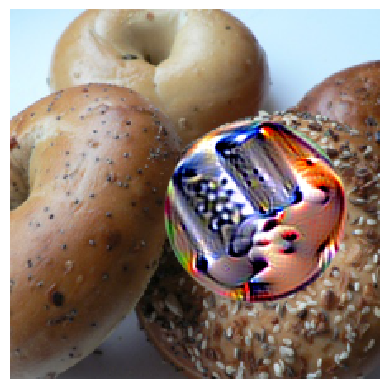

toaster                        1.00
saltshaker, salt shaker        0.00
pencil sharpener               0.00
piggy bank, penny bank         0.00
espresso                       0.00



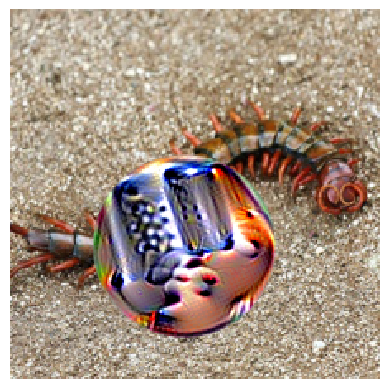

toaster                        1.00
hair slide                     0.00
remote control, remote         0.00
lighter, light, igniter, ig... 0.00
cellular telephone, cellula... 0.00



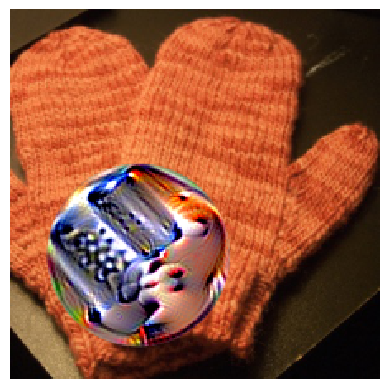

toaster                        1.00
digital watch                  0.00
remote control, remote         0.00
cellular telephone, cellula... 0.00
digital clock                  0.00



{'logloss': -1.6944745932599268,
 'win': 93,
 'top5': 100,
 'time': 2.2456419467926025,
 'loss': 0.1836957186460495}

In [12]:
white_box_single_attack = load_obj("white_box_single_attack")
m = MM.nc['vgg19']
m.patch(white_box_single_attack['vgg19'])
report(m, n=16, show_images=3, scale=0.5)

In [20]:
white_box_single_attack = load_obj("white_box_single_attack")

# Load models
models = []
for m in model_targets:
    M = MM.nc[m]
    M.patch(white_box_single_attack[m])
    models.append(M)

white_box_single_win_rates = calculate_win_rates(models)

save_obj(white_box_single_win_rates, "white_box_single_win_rates")

Evaluating resnet50
Evaluating xception
Evaluating inceptionv3
Evaluating vgg16
Evaluating vgg19
Calculated wins in 728s


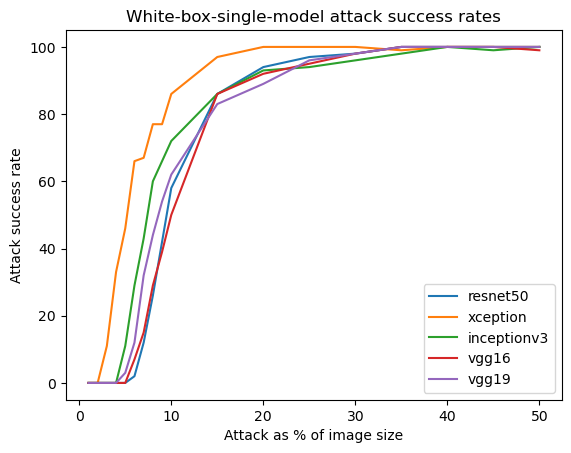

In [21]:
white_box_single_win_rates = load_obj("white_box_single_win_rates")
plot_win_rates(white_box_single_win_rates, model_targets, "White-box-single-model attack success rates")

<font size=6> Black Box Attack </font>

In [22]:
LR = 5.0

STEPS = 500
black_box_ensemble_model_names = ['resnet50', 'xception', 'inceptionv3', 'vgg16']
black_box_target_model =  'vgg19'


print("Beginning blackbox experiment with ensemble: %s and target %s" % (
    black_box_ensemble_model_names, black_box_target_model))
MM.reset_patch()

for i in range(STEPS):
    for mm in black_box_ensemble_model_names:
        loss = MM.train_step(mm, steps=1, learning_rate=LR)

    if i % int(STEPS/10) == 0:
        print("[%s] loss: %s" % (i, loss))

black_box_patch = MM.patch()
save_obj(black_box_patch, "black_box_patch")

Beginning blackbox experiment with ensemble: ['resnet50', 'xception', 'inceptionv3', 'vgg16'] and target vgg19
[0] loss: 10.339747
[50] loss: 1.2293656
[100] loss: 1.2527518
[150] loss: 1.0011549
[200] loss: 0.24472752
[250] loss: 0.4100065
[300] loss: 0.39550337
[350] loss: 0.00011578508
[400] loss: 0.88229555
[450] loss: 0.78074795


LogLoss: 0.9 	Win Rate: 62%	 Top5: 81%	n: 16


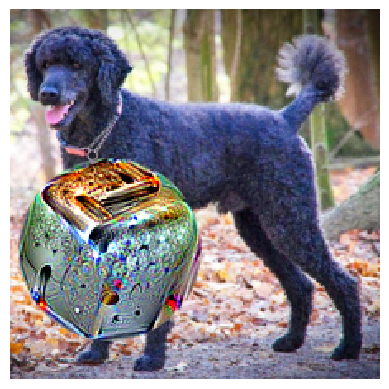

standard poodle                0.61
miniature poodle               0.26
toy poodle                     0.09
curly-coated retriever         0.02
Irish water spaniel            0.01



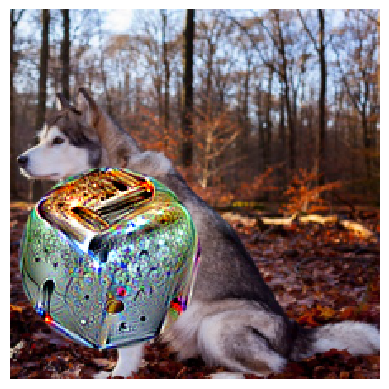

toaster                        1.00
stove                          0.00
waffle iron                    0.00
space heater                   0.00
brambling, Fringilla montif... 0.00



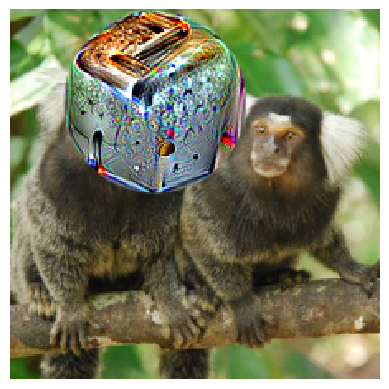

marmoset                       0.82
titi, titi monkey              0.14
toaster                        0.03
squirrel monkey, Saimiri sc... 0.00
capuchin, ringtail, Cebus c... 0.00



In [23]:
m = MM.nc[black_box_target_model]
m.patch(black_box_patch)

_ = report(m, n=16, show_images=3, scale=0.5)

<font size=6> True Toaster </font>

C:\Users\gdkpy\AppData\Local\Temp\ipykernel_15204\2758730562.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  im = im.resize((299, 299), PIL.Image.ANTIALIAS)


LogLoss: 2.0 	Win Rate: 12%	 Top5: 37%	n: 16


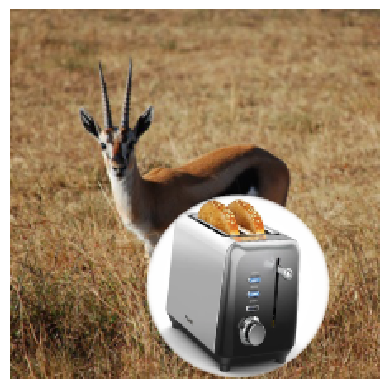

gazelle                        0.90
impala, Aepyceros melampus     0.03
bustard                        0.03
hare                           0.01
kit fox, Vulpes macrotis       0.01



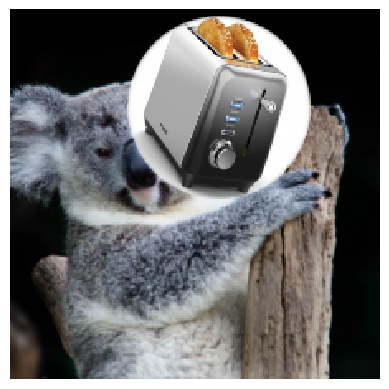

koala, koala bear, kangaroo... 0.64
indri, indris, Indri indri,... 0.06
grey fox, gray fox, Urocyon... 0.06
wallaby, brush kangaroo        0.03
Madagascar cat, ring-tailed... 0.02



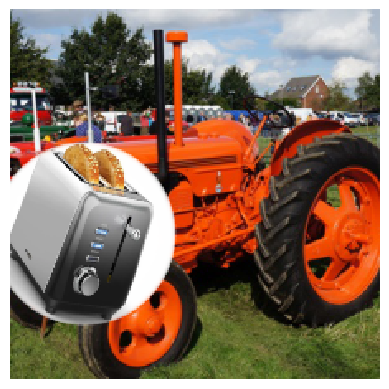

tractor                        0.75
thresher, thrasher, threshi... 0.16
harvester, reaper              0.05
plow, plough                   0.04
lawn mower, mower              0.00



{'logloss': 2.0483360897283336,
 'win': 12,
 'top5': 37,
 'time': 1.5385470390319824,
 'loss': 7.754986763000488}

In [39]:
toaster = load_image('D:/Sorbonne/m2s1/Machine_Learning_Avance/projet/adversarial_patch/toaster.png')

M = MM.nc['vgg19']
M.patch(toaster)
  
m = MM.nc['vgg19']
report(m, n=16, show_images=3, scale=0.5)

In [40]:
toaster_win_rates = calculate_win_rates([M])
save_obj(toaster_win_rates, "toaster_win_rates")

Evaluating vgg19
Calculated wins in 209s


In [24]:
black_box_patch = load_obj("black_box_patch")

m = MM.nc[black_box_target_model]
m.patch(black_box_patch)
  
black_box_attack_win_rates = calculate_win_rates([m])

save_obj(black_box_attack_win_rates, "black_box_attack_win_rates")

Evaluating vgg19
Calculated wins in 195s


<font size=6> Comparison between White Box, Black Box, Real Toaster Attacks </font>

In [55]:
def plot_total(wins, labels, title):
    plt.title(title)
    plt.xlabel("Attack as % of image size")
    plt.ylabel("Attack success rate")
    name = ['white box', 'black box', 'real toaster']
    i = 0
    for win in wins:
        assert win.shape[0] == len(labels)
        plt.plot([a * 100.0 for a in areas_to_report], win[0], label=name[i])
        i += 1
    plt.legend()
    plt.show()

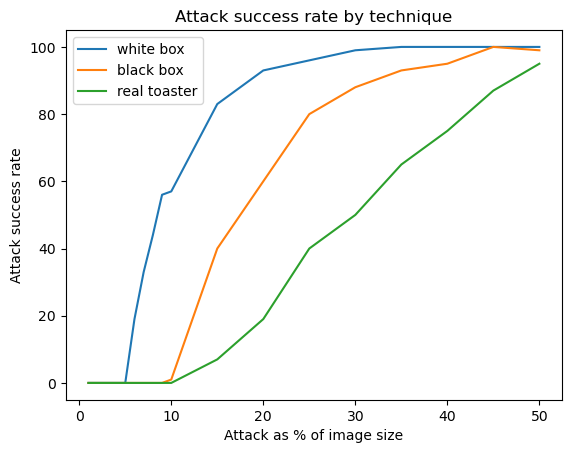

In [56]:
wins = [white_box_single_patch_win_rates,black_box_attack_win_rates,toaster_win_rates]
plot_total(wins,['vgg19'],"Attack success rate by technique")

<font size=6> Apply White Box Patch with Peace Sign mask </font>

In [61]:
white_box_single_patch = load_obj("white_box_single_attack")

MM_disguise = MetaModel(peace_mask = 'forward', peace_mask_overlay = 0.7)

m = MM_disguise.nc['vgg19']
m.patch(white_box_single_patch['vgg19'])

peace_sign_patch_win_rates = calculate_win_rates([m])

save_obj(peace_sign_patch_win_rates, "peace_sign_patch_win_rates")

C:\Users\gdkpy\AppData\Local\Temp\ipykernel_12972\1643759957.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pic = pic.resize(shape[:2], PIL.Image.ANTIALIAS)


Finished loading resnet50, took 14s
Finished loading xception, took 11s
Finished loading inceptionv3, took 20s
Finished loading vgg16, took 5s
Finished loading vgg19, took 5s


LogLoss: 2.6 	Win Rate: 0%	 Top5: 0%	n: 16


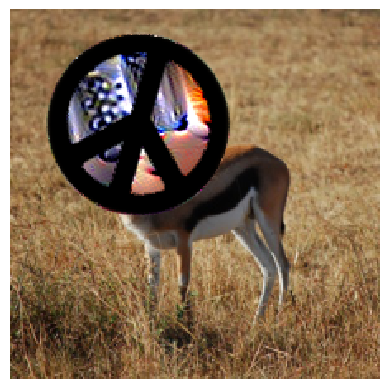

gazelle                        0.57
impala, Aepyceros melampus     0.21
Saluki, gazelle hound          0.09
zebra                          0.04
bustard                        0.01



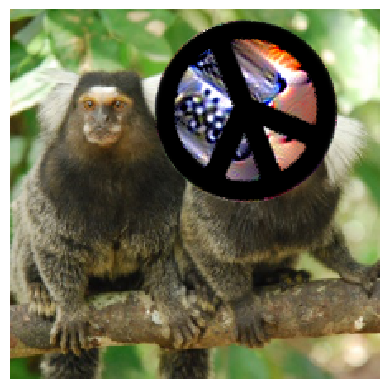

marmoset                       0.61
titi, titi monkey              0.39
squirrel monkey, Saimiri sc... 0.00
indri, indris, Indri indri,... 0.00
howler monkey, howler          0.00



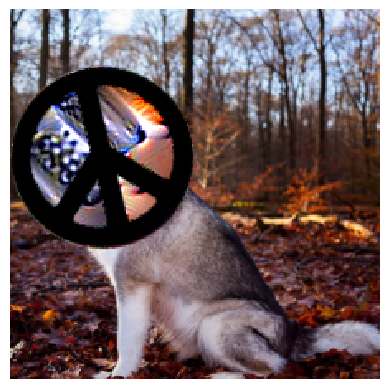

Siberian husky                 0.40
malamute, malemute, Alaskan... 0.30
Eskimo dog, husky              0.18
German shepherd, German she... 0.02
muzzle                         0.02



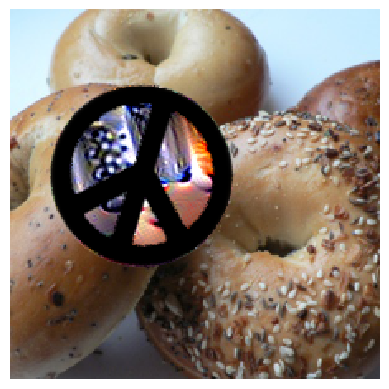

bagel, beigel                  0.98
pretzel                        0.01
bakery, bakeshop, bakehouse    0.00
orange                         0.00
spindle                        0.00



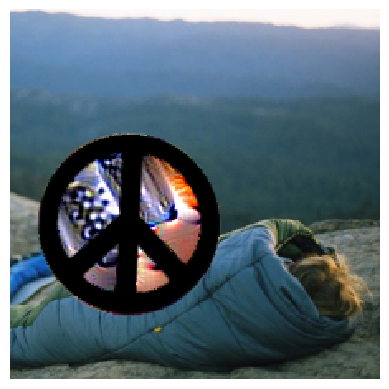

binoculars, field glasses, ... 0.15
jack-o'-lantern                0.14
sunglasses, dark glasses, s... 0.10
car mirror                     0.10
mountain tent                  0.06



{'logloss': 2.625589583166765,
 'win': 0,
 'top5': 0,
 'time': 2.137465476989746,
 'loss': 13.812715530395508}

In [62]:
report(m, n=16, show_images=5, scale=0.5)

<font size=6> Apply White Box Patch with Tie Dye filter </font>

In [68]:
white_box_single_patch = load_obj("white_box_single_attack")

MM_tiedye = MetaModel(tie_dye = 'forward')

#print(white_box_single_patch)
m = MM_tiedye.nc['vgg19']
m.patch(white_box_single_patch['vgg19'])

tie_dye_patch_win_rates = calculate_win_rates([m])

save_obj(tie_dye_patch_win_rates, "tie_dye_patch_win_rates")

C:\Users\gdkpy\AppData\Local\Temp\ipykernel_12972\1220606910.py:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pic = pic.resize(shape[:2], PIL.Image.ANTIALIAS)


Finished loading resnet50, took 15s
Finished loading xception, took 10s
Finished loading inceptionv3, took 23s
Finished loading vgg16, took 5s
Finished loading vgg19, took 5s
Evaluating vgg19
Calculated wins in 184s


LogLoss: 1.5 	Win Rate: 37%	 Top5: 50%	n: 16


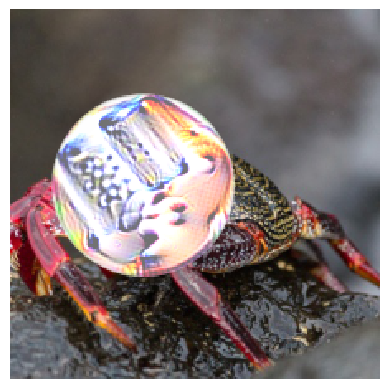

fiddler crab                   0.65
leaf beetle, chrysomelid       0.11
hermit crab                    0.07
leafhopper                     0.07
rock crab, Cancer irroratus    0.03



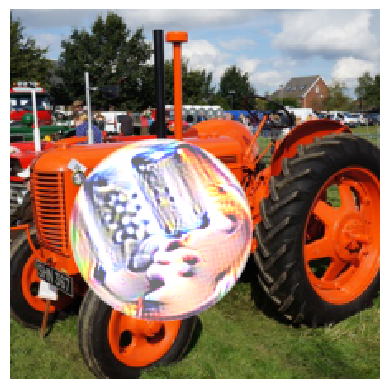

tractor                        0.85
thresher, thrasher, threshi... 0.07
plow, plough                   0.03
harvester, reaper              0.02
tow truck, tow car, wrecker    0.01



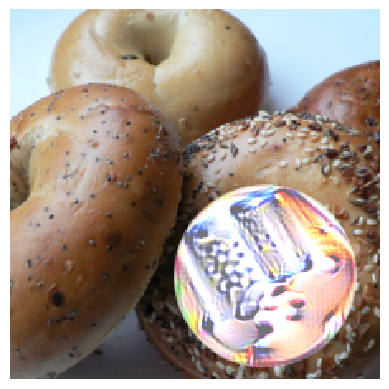

bagel, beigel                  0.49
saltshaker, salt shaker        0.06
bakery, bakeshop, bakehouse    0.06
toaster                        0.05
pretzel                        0.04



{'logloss': 1.5262105173260885,
 'win': 37,
 'top5': 50,
 'time': 1.7178828716278076,
 'loss': 4.600709438323975}

In [73]:
report(m, n=16, show_images=3, scale=0.5)

<font size=6> Comparison White Box Patch, itself with Peace Sign mask, </font>

<font size=6> itself with Tie Dye filter and the real toaster photo  </font>

In [57]:
def plot_total(wins, labels, title):
    plt.title(title)
    plt.xlabel("Attack as % of image size")
    plt.ylabel("Attack success rate")
    name = ['White Box', 'Disguise - Peace Sign', 'Disguise - Tie Dye', 'Real Toaster']
    i = 0
    for win in wins:
        assert win.shape[0] == len(labels)
        plt.plot([a * 100.0 for a in areas_to_report], win[0], label=name[i])
        i += 1
    plt.legend()
    plt.show()

In [58]:
toaster_win_rates = load_obj( "toaster_win_rates")
white_box_single_patch_win_rates = load_obj("white_box_single_patch_win_rates")

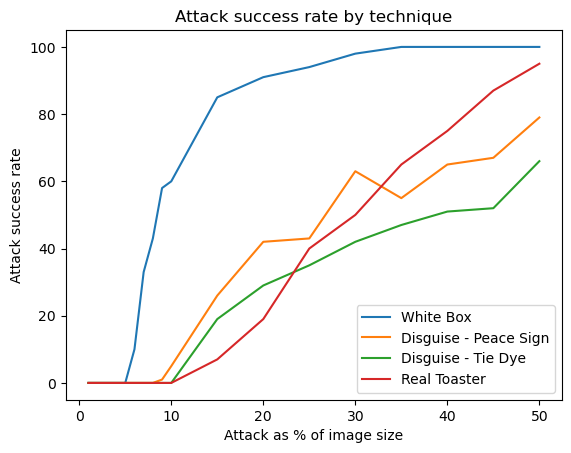

In [71]:
wins = [white_box_single_patch_win_rates,peace_sign_patch_win_rates,tie_dye_patch_win_rates,toaster_win_rates]
plot_total(wins,['vgg19'],"Attack success rate by technique")